# Analysis of tDCS effects

## 0. Data Loading and Pre-Processing

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind as ttest
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
import json

import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import bambi as bmb
print(f"Running on bmb v{bmb.__version__}")
import arviz as az
az.style.use("arviz-darkgrid") # make e.g. forestplot use a grid

# custom scripts
import dataLoader
from buttler import *

with open("./settings.json") as f:
    settings = json.load(f)

Running on PyMC v5.6.1
Running on bmb v0.12.0


In [2]:
# %%capture --no-display --no-stdout
# data loading and pre-processing
df, SESSION_IDS = dataLoader.loadCausalityData()
df = dataLoader.shiftColumns(df, ["causality_judgement", "time", "angle"], SESSION_IDS)

# add columns that count sequences of 'causal'/'non-causal' responses
df = df.groupby(SESSION_IDS, group_keys=False).apply(countResponses)
# display(df.head(3))

# select and rename needed columns
data = df [["subject_id", "baseline_stimulation", "stimulation", "group", "causality_judgement1", "time", "time1", "angle", "angle1", "c_seq", "nc_seq", "causality_judgement", "RT", "RT_corrected_for_delay"]]
data.columns = ["subj", "base_stim", "stim", "group", "c1", "time", "time1", "angle", "angle1", "c_seq", "nc_seq", "c", "rt", "rt_c"]

DATA_SESSION_IDS = ['subj', 'base_stim', 'stim', 'group']

# name categorical values
data.loc[:, "group"] = data.loc[:, "group"].replace({0: "HC", 1: "SZ"})
# data["group"] = data["group"].replace({0: "HC", 1: "SZ"}) # Has same effect and throws same error as above...
data.loc[:, "c"] = data.loc[:, "c"].replace({0: "non_causal", 1: "causal"})
data.loc[:, "c1"] = data.loc[:, "c1"].replace({0: "non_causal", 1: "causal"})
data.head(3)

Causality data shape: (42966, 10)
Shifted Data shape: (42526, 13)


subj  base_stim  stim group          c1  time  time1  angle  angle1  \
id                                                                        
1    2.0        1.0   1.0    HC      causal   0.0    4.0   30.0    22.5   
2    2.0        1.0   1.0    HC      causal  16.0    0.0   22.5    30.0   
3    2.0        1.0   1.0    HC  non_causal   0.0   16.0    0.0    22.5   

    c_seq  nc_seq           c      rt     rt_c  
id                                              
1       1       0      causal  1480.6  1480.60  
2       2       0  non_causal  1615.0  1348.44  
3       0       1      causal  1395.2  1395.20

In [3]:
# drop outlying participants
print(f"percentage of 'causal' responses for subj 16: { data[data['subj'] == 16].replace({'causal': 1, 'non_causal': 0})['c'].mean()}")
print(f"percentage of 'causal' responses for subj 104: { data[data['subj'] == 104].replace({'causal': 1, 'non_causal': 0})['c'].mean()}")

data = data[data["subj"] != 16]
data = data[data["subj"] != 104]

percentage of 'causal' responses for subj 16: 0.9830633284241531
percentage of 'causal' responses for subj 104: 1.0


In [4]:
# cap too long reaction time
# rt_limit = data["rt"].mean() + 4 * data["rt"].std() # = 3972.09 ms
rt_limit = 10000

rt_idx = data[data["rt"] >= rt_limit].index
data.loc[rt_idx, "rt"] = rt_limit

rt_c_idx = data[data["rt"] >= rt_limit].index
data.loc[rt_c_idx, "rt_c"] = rt_limit

In [5]:
# standardize data
for col in ["angle", "angle1", "time", "time1"]:
    data[col + "_std"] = standardize(data[col])

# normalize data
data = data.groupby(["subj"], group_keys=False).apply(normalize, ["rt", "rt_c", "angle", "time", "angle1", "time1"])

In [6]:
# nest data
nested_model_data, new_cols_c1 = nestPredictors(data, "c1", "group", drop_inner=False)
nested_model_data, new_cols_time = nestPredictors(nested_model_data, "time", "group", drop_inner=False)
nested_model_data, new_cols_angle = nestPredictors(nested_model_data, "angle", "group", drop_inner=False)

nested_model_data, new_cols_time = nestPredictors(nested_model_data, "time_std", "group", drop_inner=False)
nested_model_data, new_cols_angle = nestPredictors(nested_model_data, "angle_std", "group", drop_inner=False)

nested_model_data, new_cols_time = nestPredictors(nested_model_data, "time_norm", "group", drop_inner=False)
nested_model_data, new_cols_angle = nestPredictors(nested_model_data, "angle_norm", "group", drop_inner=False)

def split_tDCS(group:pd.DataFrame) -> pd.DataFrame:
    stim = group["stim"].iloc[0]
    group["tDCS_" + str(int(stim))] = group["base_stim"] == 2
    return group

nested_model_data = nested_model_data.groupby(["stim"], group_keys=False).apply(split_tDCS)

def apply_tDCS_contrasts(data:pd.DataFrame) -> pd.DataFrame:
    data2 = data.copy()
    constrasts = {
        True: 1,
        False: -1,
        np.NaN: 0
    }
    columns = ["tDCS_" + str(i+1) for i in range(7)]

    data2[columns] = data2[columns].replace(constrasts)
    return data2

nested_model_data = applyCustomConstrasts(nested_model_data, columns=["c1", "group", "c1_HC", "c1_SZ"], kind="Sum")
nested_model_data = apply_tDCS_contrasts(nested_model_data)

# custom nesting for last trial properties
nested_model_data["time1_norm_HC"] =(nested_model_data["group"] == -1) * nested_model_data["time1_norm"]
nested_model_data["time1_norm_SZ"] =(nested_model_data["group"] == 1) * nested_model_data["time1_norm"]
nested_model_data["angle1_norm_HC"] =(nested_model_data["group"] == -1) * nested_model_data["angle1_norm"]
nested_model_data["angle1_norm_SZ"] =(nested_model_data["group"] == 1) * nested_model_data["angle1_norm"]

display(nested_model_data.head(2))
print(f"We now have available the following predictors/ columns:\n{nested_model_data.columns}")

subj  base_stim  stim  group  c1  time  time1  angle  angle1  c_seq  ...  \
id                                                                       ...   
1    2.0        1.0   1.0     -1   1   0.0    4.0   30.0    22.5      1  ...   
2    2.0        1.0   1.0     -1   1  16.0    0.0   22.5    30.0      2  ...   

    tDCS_2 tDCS_3  tDCS_4  tDCS_5  tDCS_6  tDCS_7  time1_norm_HC  \
id                                                                 
1      0.0    0.0     0.0     0.0     0.0     0.0      -0.547538   
2      0.0    0.0     0.0     0.0     0.0     0.0      -1.312343   

    time1_norm_SZ  angle1_norm_HC  angle1_norm_SZ  
id                                                 
1            -0.0       -0.159477            -0.0  
2            -0.0        0.224911             0.0  

[2 rows x 49 columns]

We now have available the following predictors/ columns:
Index(['subj', 'base_stim', 'stim', 'group', 'c1', 'time', 'time1', 'angle',
       'angle1', 'c_seq', 'nc_seq', 'c', 'rt', 'rt_c', 'angle_std',
       'angle1_std', 'time_std', 'time1_std', 'rt_norm', 'rt_c_norm',
       'angle_norm', 'time_norm', 'angle1_norm', 'time1_norm', 'c1_HC',
       'c1_SZ', 'time_HC', 'time_SZ', 'angle_HC', 'angle_SZ', 'time_std_HC',
       'time_std_SZ', 'angle_std_HC', 'angle_std_SZ', 'time_norm_HC',
       'time_norm_SZ', 'angle_norm_HC', 'angle_norm_SZ', 'tDCS_1', 'tDCS_2',
       'tDCS_3', 'tDCS_4', 'tDCS_5', 'tDCS_6', 'tDCS_7', 'time1_norm_HC',
       'time1_norm_SZ', 'angle1_norm_HC', 'angle1_norm_SZ'],
      dtype='object')


### Rename time to delay

In [7]:
new_cols = []
for n in nested_model_data.columns:
    n = n.replace("time", "delay")
    new_cols.append(n)

nested_model_data.columns = new_cols
# nested_model_data.columns

## 1. GLMMs for tDCS effect

In [8]:
TRACE_PATH = os.path.join(settings["trace_path"], "causality", "tDCS")
os.makedirs(TRACE_PATH, exist_ok=True)

### 1.1 Naively fitting a way too complex model: Does not converge

In [9]:
# WARNING: Does take 24 h to not converge!

# trace_file = os.path.join(TRACE_PATH, "g_x_d_x_a_x_c1_x_a1_x_d1_x_bs_s_ri.nc") # tdcs_full_int

# model_g_x_d_x_a_x_c1_x_a1_x_d1_x_bs_s_ri = bmb.Model("c ~ group*delay_norm*angle_norm*c1*angle1_norm*delay1_norm*base_stim*stim + (1|subj)", nested_model_data, family="bernoulli")
# trace_g_x_d_x_a_x_c1_x_a1_x_d1_x_bs_s_ri = loadOrSample(model_g_x_d_x_a_x_c1_x_a1_x_d1_x_bs_s_ri, trace_file)

### 1.2. Choice-history model (but no trial-history)

3 of 4 chains of below model converged. The fourth chain is still chaining down Cerberus.
That means this is still a little bit too complicated

In [10]:
trace_file = os.path.join(TRACE_PATH, "tdcs_full_int.nc")

model_tdcs_full = bmb.Model("c ~ group*delay_norm*angle_norm*c1*base_stim*stim + (1|subj)", nested_model_data, family="bernoulli")
trace_tdcs_full = loadOrSample(model_tdcs_full, trace_file)

Loading trace from file.


check if there is confidence in the following effects:
*  base_stim x stim x angle
*  base_stim x stim x delay
*  base_stim x stim x angle x delay
*  base_stim x stim x c1
*  base_stim x stim x angle x c1
*  base_stim x stim x delay x c1
*  base_stim x stim x angle x delay x c1

There should be a considerable/significant base_stim x stim x angle effect.

In [11]:
summary = az.summary(trace_tdcs_full, var_names=["group", "delay_norm", "angle_norm", "c1", "base_stim", "stim",
                                       "angle_norm:base_stim:stim", "delay_norm:base_stim:stim", "c1:base_stim:stim",
                                       "group:angle_norm:base_stim:stim", "group:delay_norm:base_stim:stim", "group:c1:base_stim:stim"
                                       # ...
                                       ])
display(summary)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
group                           -0.110  0.191  -0.482    0.215      0.007   
delay_norm                      -0.895  0.095  -1.070   -0.712      0.002   
angle_norm                      -0.638  0.094  -0.816   -0.467      0.002   
c1                               0.069  0.087  -0.101    0.226      0.002   
base_stim                        0.052  0.057  -0.056    0.159      0.001   
stim                             0.005  0.020  -0.032    0.041      0.000   
angle_norm:base_stim:stim       -0.025  0.013  -0.050   -0.001      0.000   
delay_norm:base_stim:stim       -0.017  0.014  -0.040    0.010      0.000   
c1:base_stim:stim               -0.015  0.012  -0.038    0.009      0.000   
group:angle_norm:base_stim:stim -0.030  0.013  -0.055   -0.005      0.000   
group:delay_norm:base_stim:stim  0.027  0.014   0.002    0.053      0.000   
group:c1:base_stim:stim          0.009  0.012  -0.015    0.031      0.000   

                                 mcse_sd  ess_bulk  ess_tail  r_hat  
group                              0.005     708.0    1234.0    1.0  
delay_norm                         0.001    2578.0    1927.0    1.0  
angle_norm                         0.001    2506.0    2148.0    1.0  
c1                                 0.001    3177.0    2375.0    1.0  
base_stim                          0.001    3408.0    2276.0    1.0  
stim                               0.000    3109.0    2081.0    1.0  
angle_norm:base_stim:stim          0.000    2457.0    2199.0    1.0  
delay_norm:base_stim:stim          0.000    2425.0    1684.0    1.0  
c1:base_stim:stim                  0.000    3238.0    2234.0    1.0  
group:angle_norm:base_stim:stim    0.000    2859.0    1657.0    1.0  
group:delay_norm:base_stim:stim    0.000    2807.0    1960.0    1.0  
group:c1:base_stim:stim            0.000    3278.0    2299.0    1.0

Split up for the groups:

In [12]:
mysum = {}
mysum["angle:base_stim:stim_HC"] = trace_tdcs_full.posterior["angle_norm:base_stim:stim"] - trace_tdcs_full.posterior["group:angle_norm:base_stim:stim"]
mysum["angle:base_stim:stim_SSD"] = trace_tdcs_full.posterior["angle_norm:base_stim:stim"] + trace_tdcs_full.posterior["group:angle_norm:base_stim:stim"]
mysum["delay:base_stim:stim_HC"] = trace_tdcs_full.posterior["delay_norm:base_stim:stim"] - trace_tdcs_full.posterior["group:delay_norm:base_stim:stim"]
mysum["delay:base_stim:stim_SSD"] = trace_tdcs_full.posterior["delay_norm:base_stim:stim"] + trace_tdcs_full.posterior["group:delay_norm:base_stim:stim"]
mysum["c1:base_stim:stim_HC"] = trace_tdcs_full.posterior["c1:base_stim:stim"] - trace_tdcs_full.posterior["group:c1:base_stim:stim"]
mysum["c1:base_stim:stim_SSD"] = trace_tdcs_full.posterior["c1:base_stim:stim"] + trace_tdcs_full.posterior["group:c1:base_stim:stim"]

In [13]:
for key in mysum:
    print(key)
    display(az.summary(mysum[key]))

angle:base_stim:stim_HC


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x  0.005  0.017  -0.028    0.034        0.0      0.0    2751.0    1787.0   

   r_hat  
x    1.0

angle:base_stim:stim_SSD


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
x -0.055  0.02  -0.093   -0.016        0.0      0.0    2356.0    1958.0    1.0

delay:base_stim:stim_HC


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -0.044  0.019  -0.079   -0.008        0.0      0.0    2707.0    2137.0   

   r_hat  
x    1.0

delay:base_stim:stim_SSD


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x  0.011  0.019  -0.023    0.049        0.0      0.0    2500.0    2096.0   

   r_hat  
x    1.0

c1:base_stim:stim_HC


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -0.024  0.016  -0.054    0.006        0.0      0.0    3403.0    2608.0   

   r_hat  
x    1.0

c1:base_stim:stim_SSD


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
x -0.007  0.019  -0.042    0.027        0.0      0.0    3255.0    2112.0   

   r_hat  
x    1.0

Results:  <br>
The model suggests that there are considerable effects for
* The angle effect in SSDs
* The delay effect in HCs

All other interactions are not reported to be different from zero with confidence.

### 1.3. A model with choice- and trial-history but only selected interaction effects fitted on tDCS sessions separately

Results: <br>
The models suggest several interactions with the tDCS stimulation for each stimulation condition. 
Most interactions were found for stimulation condition 5 (LFC-RPA).
These results don't offer a concrete interpretation though.


{1.0: ['delay_norm:angle_norm:c1:base_stim',
  'angle_norm:c1:angle1_norm:base_stim',
  'delay_norm:c1:delay1_norm:base_stim'],
 3.0: ['base_stim', 'c1:base_stim'],
 5.0: ['group:base_stim',
  'delay_norm:base_stim',
  'angle_norm:base_stim',
  'group:angle_norm:base_stim',
  'group:delay_norm:base_stim',
  'angle_norm:c1:angle1_norm:base_stim',
  'group:angle_norm:c1:angle1_norm:base_stim',
  'group:delay1_norm:base_stim'],
 7.0: ['delay_norm:base_stim',
  'angle_norm:base_stim',
  'group:delay_norm:base_stim']}

In [14]:
# tdcs_data = nested_model_data.copy()
# tdcs_data.loc[:, "base_stim"] = tdcs_data.loc[:, "base_stim"].replace({1.0: -1, 2.0:1})

$$\begin{align}
c \sim & g + \delta + \alpha + c_1 + \alpha_1 + \delta_1 + s + (1|subj) \\
& + g:s + \delta:s + \alpha:s + c_1:s + \alpha_1:s + \delta_1:s \\
& + g:\alpha + g:\delta \\
& + g:\alpha:s + g:\delta:s \\
& + g:c_1 + \delta:c_1 + g:\delta:c_1 + \alpha:c_1 + g:\alpha:c_1 + \delta:\alpha:c_1 \\
& + g:c_1:s + \delta:c_1:s + g:\delta:c_1:s + \alpha:c_1:s + g:\alpha:c_1:s + \delta:\alpha:c_1:s \\
& + g:\alpha_1 + \alpha:\alpha_1 + c_1:\alpha_1 + g:c_1:\alpha_1 + \alpha:c_1:\alpha_1 + g:\alpha:c_1:\alpha_1\\
& + g:\alpha_1:s + \alpha:\alpha_1:s + c_1:\alpha_1:s + g:c_1:\alpha_1:s + \alpha:c_1:\alpha_1:s + g:\alpha:c_1:\alpha_1:s\\
& + g:\delta_1 + \delta:\delta_1 + c_1:\delta_1 + g:c_1:\delta_1 + \delta:c_1:\delta_1 + g:\delta:c_1:\delta_1\\
& + g:\delta_1:s + \delta:\delta_1:s + c_1:\delta_1:s + g:c_1:\delta_1:s + \delta:c_1:\delta_1:s + g:\delta:c_1:\delta_1:s\\
\end{align}$$

In [15]:
# # prepare data
# tdata = {}
# # for key in nested_model_data["stim"].unique(): # we don't have HC data for stims 2, 4, 6!
# for key in [1., 3., 5., 7.]:
#     tdata[key]= nested_model_data[nested_model_data["stim"] == key]

# #prepare file name
# trace_file_base_name = "tdcs_ch_th_interactiosn_selected"

# # prepare model string
# model_string = "c ~ group + delay_norm + angle_norm + c1 + angle1_norm + delay1_norm + base_stim + (1|subj)"
# model_string +=  " + group:base_stim + delay_norm:base_stim + angle_norm:base_stim + c1:base_stim + angle1_norm:base_stim + delay1_norm:base_stim"
# # add interaction effects worth considering
# model_string += " + group:angle_norm + group:delay_norm"
# model_string += " + group:angle_norm:base_stim + group:delay_norm:base_stim"

# model_string += " + group:c1 + delay_norm:c1 + group:delay_norm:c1 + angle_norm:c1 + group:angle_norm:c1 + delay_norm:angle_norm:c1"
# model_string += " + group:c1:base_stim + delay_norm:c1:base_stim + group:delay_norm:c1:base_stim + angle_norm:c1:base_stim + group:angle_norm:c1:base_stim + delay_norm:angle_norm:c1:base_stim"

# model_string += " + group:angle1_norm + angle_norm:angle1_norm + c1:angle1_norm + group:c1:angle1_norm + angle_norm:c1:angle1_norm + group:angle_norm:c1:angle1_norm"
# model_string += " + group:angle1_norm:base_stim + angle_norm:angle1_norm:base_stim + c1:angle1_norm:base_stim + group:c1:angle1_norm:base_stim + angle_norm:c1:angle1_norm:base_stim + group:angle_norm:c1:angle1_norm:base_stim"

# model_string += " + group:delay1_norm + delay_norm:delay1_norm + c1:delay1_norm + group:c1:delay1_norm + delay_norm:c1:delay1_norm + group:delay_norm:c1:delay1_norm"
# model_string += " + group:delay1_norm:base_stim + delay_norm:delay1_norm:base_stim + c1:delay1_norm:base_stim + group:c1:delay1_norm:base_stim + delay_norm:c1:delay1_norm:base_stim + group:delay_norm:c1:delay1_norm:base_stim"

In [16]:
# # sampel a model for each tDCS stimulation
# tmodels = {}
# ttraces = {}
# for key in tdata:
#     file_name = trace_file_base_name + "_" + str(int(key))
#     print(f"Fitting model: {file_name}")
#     trace_file = os.path.join(TRACE_PATH, file_name + ".nc")

#     tmodels[key] = bmb.Model(model_string, tdata[key], family="bernoulli")
#     ttraces[key] = loadOrSample(tmodels[key], trace_file)

Lets first just look at the stim params, if they are significant somewhere:

In [17]:
# def sign(num):
#     return -1 if num < 0 else 1

In [18]:
# # let us extract those parameters considered relevantly different after tDCS stimulation by the model
# vars = az.summary(ttraces[1]).index.values
# stim_vars = [v for v in vars if "base_stim" in v]
# stim_vars_rel = {}
# for key in ttraces:
#     summary = az.summary(ttraces[key], stim_vars)
#     stim_vars_rel[key] = [i for i in summary.index.values if sign(summary.loc[i, "hdi_3%"]) == sign(summary.loc[i, "hdi_97%"])]

In [19]:
# stim_vars_rel

In [20]:
# # unravel pre-post effects
# # and unravel group differences
# posts = {}
# effects = []
# for key in ttraces:
#     posts[key] = ttraces[key].posterior.to_dataframe().reset_index().drop(columns=["1|subj_sigma", "1|subj", "subj__factor_dim"]).drop_duplicates()
#     for col in posts[key].columns:
#         # if "group:" in col:
#         #     base_effect = col[6:]
#         #     posts[key].loc[:, base_effect + "_HC"] = posts[key].loc[:, base_effect] - posts[key].loc[:, col]
#         #     posts[key].loc[:, base_effect + "_SSD"] = posts[key].loc[:, base_effect] + posts[key].loc[:, col]
#         if ":base_stim" in col:
#             base_effect = col[:-10]
#             posts[key].loc[:, base_effect + "_pre"] = posts[key].loc[:, base_effect] - posts[key].loc[:, col]
#             posts[key].loc[:, base_effect + "_post"] = posts[key].loc[:, base_effect] + posts[key].loc[:, col]
#             effects.append(base_effect)

# pre_effects = [x + "_pre" for x in effects]
# post_effects = [x + "_post" for x in effects]

In [21]:
# # sns.scatterplot(comps[1].T)
# # for key in posts:
# a = posts[key].loc[:, pre_effects].stack().reset_index()
# a.columns=["tid", "param", "value"]
# a["param"] = [x[:-4] for x in a["param"]]
# a["stim"] = "pre"
# b = posts[key].loc[:, post_effects].stack().reset_index()
# b.columns=["tid", "param", "value"]
# b["param"] = [x[:-5] for x in b["param"]]
# b["stim"] = "post"
# # sns.barplot(a, x="value", y="param")
# c = pd.concat([a, b])

# fig, axs = plt.subplots(1, 1, figsize=(10, 8))

# sns.boxenplot(c, x="value", y="param", hue="stim", ax=axs)
# plt.show()

## 2. Comparing data

Take home message:

There seems to be a mislabelling in the provided data:<br>
Here, angle effects occurr (if any) in tDCS condition 5 (lfc-rpa), however, Schülke et al. reported tDCS effects for contidion 3 (lpc-rpa).

In [22]:
# from scipy.stats import ttest_ind

# FDR = 0.20

# def ttest_stim(group:pd.DataFrame, var):
#     a = group[group["base_stim"] == 1]["c"]
#     b = group[group["base_stim"] == 2]["c"]
#     t, p = ttest_ind(a, b)
#     a = pd.DataFrame(columns=["p", "t"], index=[0])
#     a.loc[:, "p"] = round(p, 3)
#     a.loc[:, "t"] = round(t, 3)
#     a.loc[:, var] = group[var].iloc[0]
#     return a

# def get_BH_corrected_p(df):
#     """return Benjamini-Hochberg corrected p-value of tests
#     Args:
#         df (_type_): _description_
#     Returns:
#         _type_: _description_
#     """
#     p_crit = np.nan
#     for n, row in df.iterrows():
#         if row["p"] <= row["p_crit"]:
#             p_crit = row["p"]
#     return p_crit


# def assemble_ttest_stats(data_dict, var, fdr):
#     tts = {}
#     for i, stim in enumerate(data_dict):
#         pltdf = data_dict[stim].replace({"causal": 1, "non_causal": 0})
#         ttdf = pltdf.groupby([var], group_keys=False).apply(ttest_stim, var)
#         ttdf.index = range(ttdf.shape[0])
#         ttdf = ttdf.sort_values("p")
#         ttdf["rank"] = range(1, ttdf.shape[0] + 1)

#         # FDR correction
#         ttdf["p_crit"] = ttdf["rank"] / ttdf.shape[0] * fdr

#         tts[stim] = ttdf

#     return tts

Angle

Significant is only the difference at angle 7.5 ° in tDCS condition 5 (lfc-rpa)

In [23]:
# var = "angle"
# tts = assemble_ttest_stats(tdata, var, FDR)
# for key in tts:
#     print(f"{key}, {var}: {get_BH_corrected_p(tts[key])}")

In [24]:
# fig, axs = plt.subplots(1, 4, figsize=(16, 5))
# axs = axs.flatten()

# for i, stim in enumerate(tdata):
#     pltdf = tdata[stim].replace({"causal": 1, "non_causal": 0})
#     a = pltdf[[var, "base_stim", "c"]].groupby([var, "base_stim"], group_keys=False).mean()
#     a = a.reset_index()
#     sns.barplot(pltdf, x=var, y="c", hue="base_stim", ax=axs[i], errorbar='ci')

Delay

Nothing significant here

In [25]:
# var = "delay"
# tts = assemble_ttest_stats(tdata, var, FDR)
# for key in tts:
#     print(f"{key}, {var}: {get_BH_corrected_p(tts[key])}")

In [26]:
# fig, axs = plt.subplots(1, 4, figsize=(16, 5))
# axs = axs.flatten()

# for i, stim in enumerate(tdata):
#     pltdf = tdata[stim].replace({"causal": 1, "non_causal": 0})
#     a = pltdf[[var, "base_stim", "c"]].groupby([var, "base_stim"], group_keys=False).mean()
#     a = a.reset_index()
#     sns.barplot(pltdf, x=var, y="c", hue="base_stim", ax=axs[i], errorbar='ci')

Choice history

Interestingly, here the differences at c1=1 for tDCS conditions 1 (lfc-rfa) and 3 (lpc-rpa) are significant

In [27]:
# var = "c1"
# tts = assemble_ttest_stats(tdata, var, FDR)
# for key in tts:
#     print(f"{key}, {var}: {get_BH_corrected_p(tts[key])}")

In [28]:
# fig, axs = plt.subplots(1, 4, figsize=(16, 5))
# axs = axs.flatten()

# for i, stim in enumerate(tdata):
#     pltdf = tdata[stim].replace({"causal": 1, "non_causal": 0})
#     a = pltdf[[var, "base_stim", "c"]].groupby([var, "base_stim"], group_keys=False).mean()
#     a = a.reset_index()
#     sns.barplot(pltdf, x=var, y="c", hue="base_stim", ax=axs[i], errorbar='ci')

Angle_history

Here, the differences at 30 ° for tDCS condition 3 and at angles 15° and 22.5° for tDCS condition 5 are significant

In [29]:
# var = "angle1"
# tts = assemble_ttest_stats(tdata, var, FDR)
# for key in tts:
#     print(f"{key}, {var}: {get_BH_corrected_p(tts[key])}")

In [30]:
# var = "angle1"
# fig, axs = plt.subplots(1, 4, figsize=(16, 5))
# axs = axs.flatten()

# for i, stim in enumerate(tdata):
#     pltdf = tdata[stim].replace({"causal": 1, "non_causal": 0})
#     a = pltdf[[var, "base_stim", "c"]].groupby([var, "base_stim"], group_keys=False).mean()
#     a = a.reset_index()
#     sns.barplot(pltdf, x=var, y="c", hue="base_stim", ax=axs[i], errorbar='ci')

Delay history

Here, delay of 2 frames in tDCS condition 1 and delay of 2 and 8 frames in tDCS condition 5 are significant

In [31]:
# var = "delay1"
# tts = assemble_ttest_stats(tdata, var, FDR)
# for key in tts:
#     print(f"{key}, {var}: {get_BH_corrected_p(tts[key])}")

In [32]:
# var = "delay1"
# fig, axs = plt.subplots(1, 4, figsize=(16, 5))
# axs = axs.flatten()

# for i, stim in enumerate(tdata):
#     pltdf = tdata[stim].replace({"causal": 1, "non_causal": 0})
#     a = pltdf[[var, "base_stim", "c"]].groupby([var, "base_stim"], group_keys=False).mean()
#     a = a.reset_index()
#     sns.barplot(pltdf, x=var, y="c", hue="base_stim", ax=axs[i], errorbar='ci')

## 3. Replicating the plots from Schülke et al.

It really looks like there was a label mixup between label 3 and 5. Otherwise the results are congruent.

In [33]:
import itertools

sz = nested_model_data[nested_model_data["group"] == 1].replace({"causal": 1, "non_causal": 0})
hc = nested_model_data[nested_model_data["group"] == -1].replace({"causal": 1, "non_causal": 0})

# convert delay to ms
sz["delay"] = round(sz["delay"] * 1/60 * 1000, 2)#.astype(int)
hc["delay"] = round(hc["delay"] * 1/60 * 1000, 2)#.astype(int)

sz["base_stim"] = sz["base_stim"].replace({1: "pre", 2: "post"})
hc["base_stim"] = hc["base_stim"].replace({1: "pre", 2: "post"})

stim_mapping = {
    1: "LFC-RFA",
    2: "LFA-RFC",
    3: "LPC-RPA",
    4: "LPA-RPC",
    5: "LFC-RPA",
    6: "LFA-RPC",
    7: "sham"
}

sz["stim"] = sz["stim"].astype(int).replace(stim_mapping)
hc["stim"] = hc["stim"].astype(int).replace(stim_mapping)

sz["bs-stim"] = sz["base_stim"].astype(str).str.cat(": " + sz["stim"].astype(str))
hc["bs-stim"] = hc["base_stim"].astype(str).str.cat(": " + hc["stim"].astype(str))

hc_colors = ["orange", "orange", "steelblue", "steelblue", "red", "red", "darkgreen", "darkgreen", "purple", "purple", "brown", "brown", "grey", "grey"]
sz_colors = ["orange", "orange", "red", "red", "purple", "purple", "grey", "grey"]

In [34]:
def addBarPatterns(g, n_vals):
    hatches = itertools.cycle(['']*n_vals + ['///'] * n_vals)
    for i, bar in enumerate(g.patches):
        # if (i+1) % n_bs_stim == 0:
        #     hatch = next(hatches)

        hatch = next(hatches)
        # print(hatch)
        # if i % n_bs_stim == 0:
        bar.set_hatch(hatch)
    return

Angle

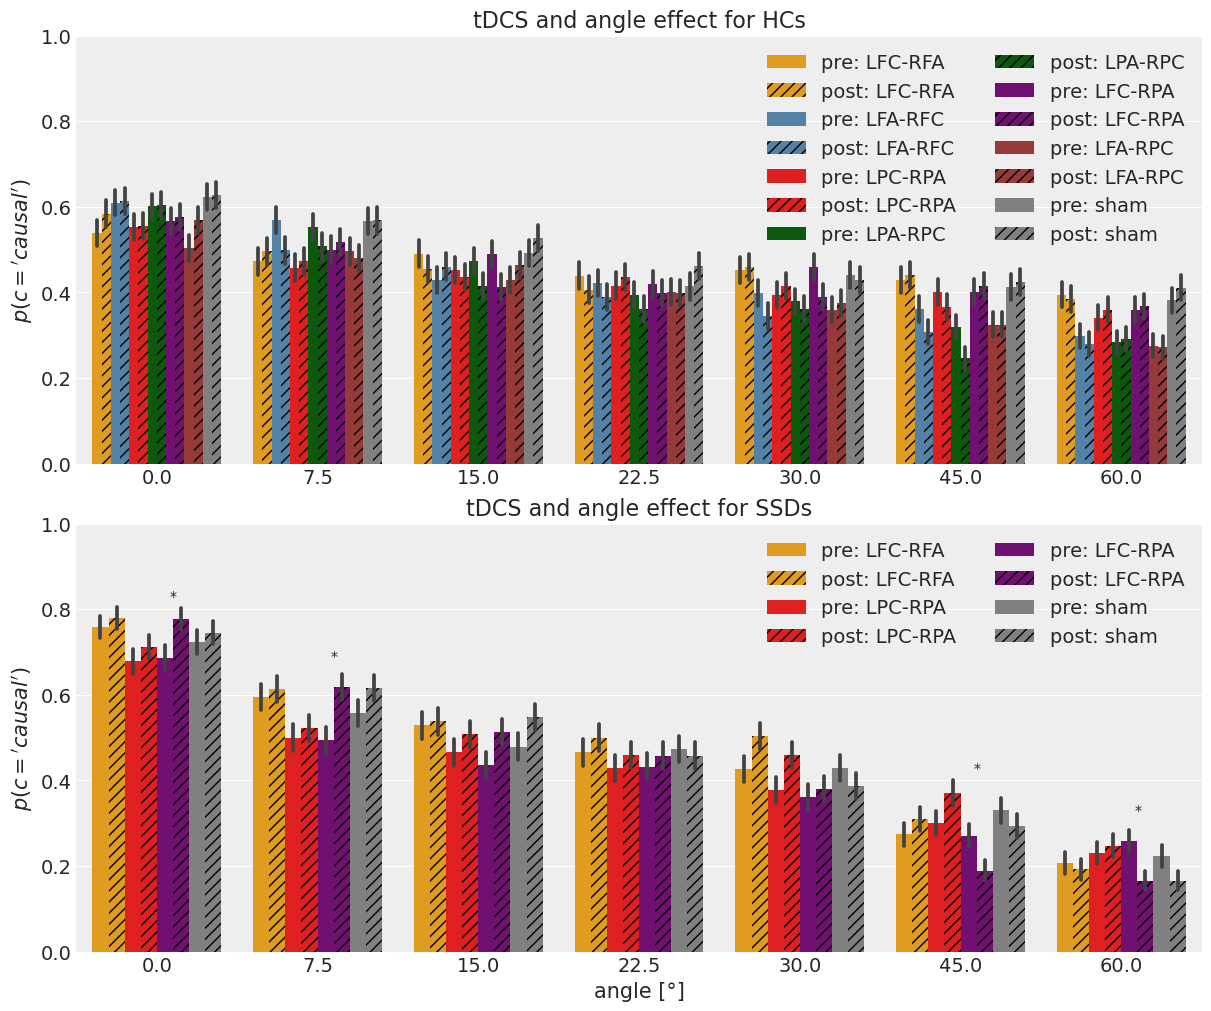

In [ ]:
var = "angle"

fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs = axs.flatten()


df = hc
n_bs_stim = len(df["bs-stim"].unique())
n_vals = len(df[var].unique())

g = sns.barplot(df, x=var, y="c", hue="bs-stim", palette=hc_colors, errorbar="se", ax=axs[0])
addBarPatterns(g, n_vals)


df = sz
n_bs_stim = len(df["bs-stim"].unique())
n_vals = len(df[var].unique())

g = sns.barplot(df, x=var, y="c", hue="bs-stim", palette=sz_colors, errorbar="se", ax=axs[1])
addBarPatterns(g, n_vals)


### Styling
for ax in axs:
    ax.set_ylabel("$p(c='causal')$")
    ax.set_xlabel("")
    ax.set_ylim(0, 1)

axs[0].legend(ncols=2)
axs[1].legend(ncols=2)

axs[1].set_xlabel("angle [°]")

axs[0].set_title("tDCS and angle effect for HCs")
axs[1].set_title("tDCS and angle effect for SSDs")

# mark significant differences
axs[1].text(0.08, 0.82, "*")
axs[1].text(1.08, 0.68, "*")
axs[1].text(5.08, 0.42, "*")
axs[1].text(6.08, 0.32, "*")

plt.tight_layout()

# plt.savefig("figures/tdcs_data_angle.pdf")

Delay

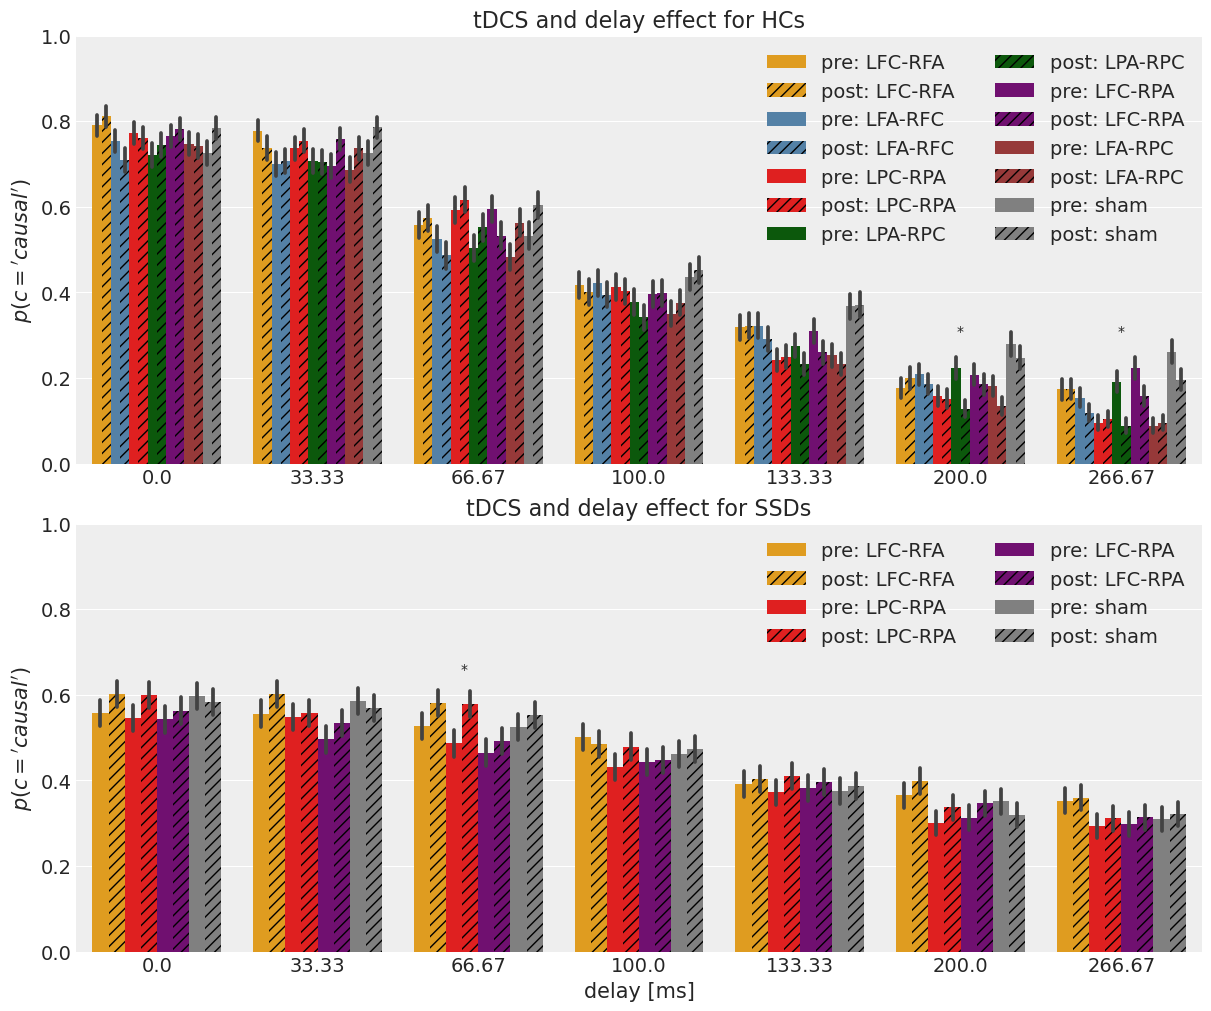

In [36]:
var = "delay"

fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs = axs.flatten()


df = hc
n_bs_stim = len(df["bs-stim"].unique())
n_vals = len(df[var].unique())

g = sns.barplot(df, x=var, y="c", hue="bs-stim", palette=hc_colors, errorbar="se", ax=axs[0])
addBarPatterns(g, n_vals)

df = sz
n_bs_stim = len(df["bs-stim"].unique())
n_vals = len(df[var].unique())

g = sns.barplot(df, x=var, y="c", hue="bs-stim", palette=sz_colors, errorbar="se", ax=axs[1])
addBarPatterns(g, n_vals)

### Styling
for ax in axs:
    ax.set_ylabel("$p(c='causal')$")
    ax.set_xlabel("")
    ax.set_ylim(0, 1)

axs[0].legend(ncols=2)
axs[1].legend(ncols=2)

axs[1].set_xlabel("delay [ms]")

axs[0].set_title("tDCS and delay effect for HCs")
axs[1].set_title("tDCS and delay effect for SSDs")

# mark significant differences
axs[0].text(5- 0.025, 0.3, "*")
axs[0].text(6- 0.025, 0.3, "*")

axs[1].text(2 - 0.11, 0.65, "*")

plt.tight_layout()

# plt.savefig("figures/tdcs_data_delay.pdf")

Choice-history

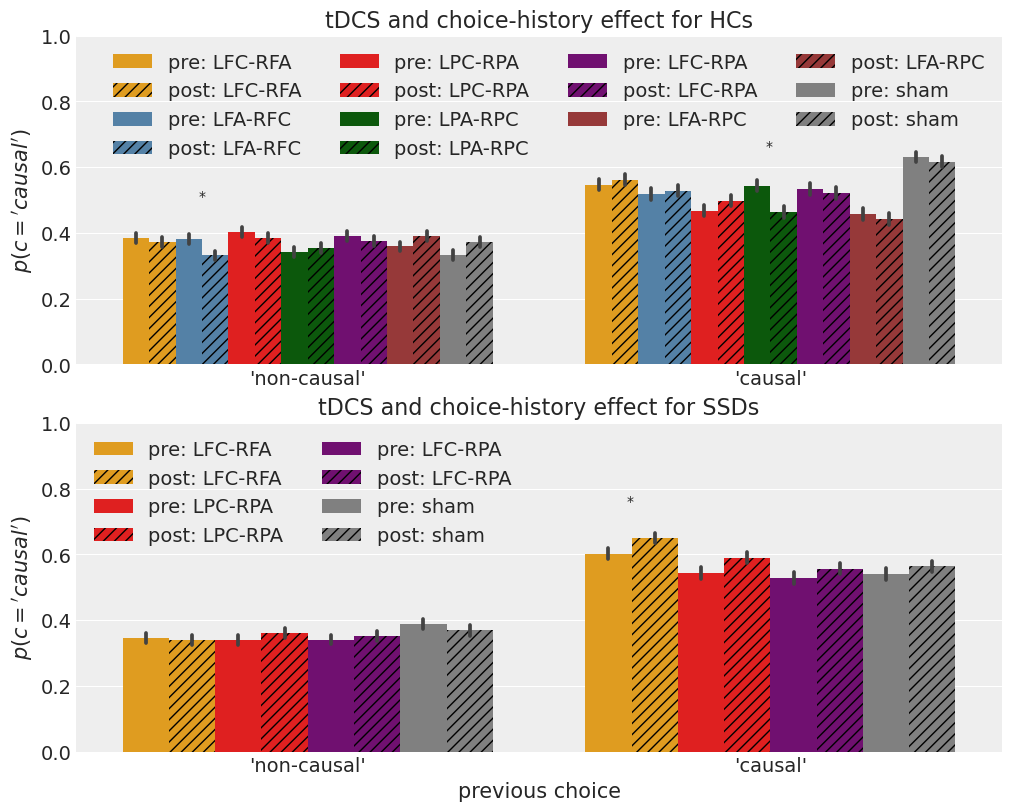

In [37]:
var = "c1"

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs = axs.flatten()


df = hc
n_bs_stim = len(df["bs-stim"].unique())
n_vals = len(df[var].unique())

g = sns.barplot(df, x=var, y="c", hue="bs-stim", palette=hc_colors, errorbar="se", ax=axs[0])
addBarPatterns(g, n_vals)

df = sz
n_bs_stim = len(df["bs-stim"].unique())
n_vals = len(df[var].unique())

g = sns.barplot(df, x=var, y="c", hue="bs-stim", palette=sz_colors, errorbar="se", ax=axs[1])
addBarPatterns(g, n_vals)

### Styling
for ax in axs:
    ax.set_ylabel("$p(c='causal')$")
    ax.set_xlabel("")
    ax.set_ylim(0, 1)
    ax.set_xticklabels(["'non-causal'", "'causal'"])

axs[0].legend(ncols=4)
axs[1].legend(ncols=2)

axs[1].set_xlabel("previous choice")

axs[0].set_title("tDCS and choice-history effect for HCs")
axs[1].set_title("tDCS and choice-history effect for SSDs")

# mark significant differences
axs[0].text(0 - 0.235, 0.5, "*")
axs[0].text(1 - 0.01, 0.65, "*")

axs[1].text(1 - 0.31, 0.75, "*")

plt.tight_layout()

# plt.savefig("figures/tdcs_data_c1.pdf")

Let's try testing for significance of stimulation for these variables

In [38]:
def test_ttest_significance(data, variable:str, group:int):
    """Test for all data of group for each value of variable for each value of "stim", whether there is a significant difference between base_stim = 1 and base_stim = 2
    Args:
        data (_type_): _description_
        variable (str): _description_
        group (int): _description_
    """
    print("--- SSDs ---" if group == 1 else "--- HCs ---")
    data = data[data["group"] == group].replace({"non_causal": 0, "causal": 1})

    print(f"Variable: {variable}")
    values = data[variable].unique()
    values.sort()

    for val in values:
        print(f"\t{val}")
        for stim in data["stim"].unique():
            pre = data[(data[variable] == val) & (data["stim"] == stim) & (data["base_stim"] == 1)]["c"]
            post = data[(data[variable] == val) & (data["stim"] == stim) & (data["base_stim"] == 2)]["c"]
            res = ttest(pre, post)
            print(f"\t\tstim {stim}: {res}")

test_ttest_significance(nested_model_data, "c1", 1)

--- SSDs ---
Variable: c1
	-1
		stim 1.0: TtestResult(statistic=0.37928152435769974, pvalue=0.7045206503338475, df=1925.0)
		stim 3.0: TtestResult(statistic=-1.0961564962342645, pvalue=0.273139932566891, df=2036.0)
		stim 5.0: TtestResult(statistic=-0.49020797968281465, pvalue=0.6240387876331543, df=2066.0)
		stim 7.0: TtestResult(statistic=0.9375555906082179, pvalue=0.3485869563837982, df=1984.0)
	1
		stim 1.0: TtestResult(statistic=-2.070334598747032, pvalue=0.038566887534614236, df=1756.0)
		stim 3.0: TtestResult(statistic=-1.9101044007410641, pvalue=0.05629414724703146, df=1639.0)
		stim 5.0: TtestResult(statistic=-1.1187224303115828, pvalue=0.26342873338792266, df=1579.0)
		stim 7.0: TtestResult(statistic=-0.9604420032810443, pvalue=0.3369711775101075, df=1678.0)
